# Self-Driving Car Engineer Nanodegree

## Project03: Build a Traffic Sign Recognition Classifier

In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.keras.layers import Flatten
from sklearn.utils import shuffle
import os
import time
import pickle
import collections
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


---
## Step 0: Load The Data

In [22]:
# Load pickled data
training_file = './traffic-signs-data/train.p'
validation_file='./traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
### Basic Summary of the Data Set

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(collections.Counter(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [4]:
signnames = pd.read_csv('./signnames.csv')
signnames.set_index('ClassId',inplace=True)

def get_name_from_label(label):
    # Helper, transofrm a numeric label into the corresponding strring
    return signnames.loc[label].SignName

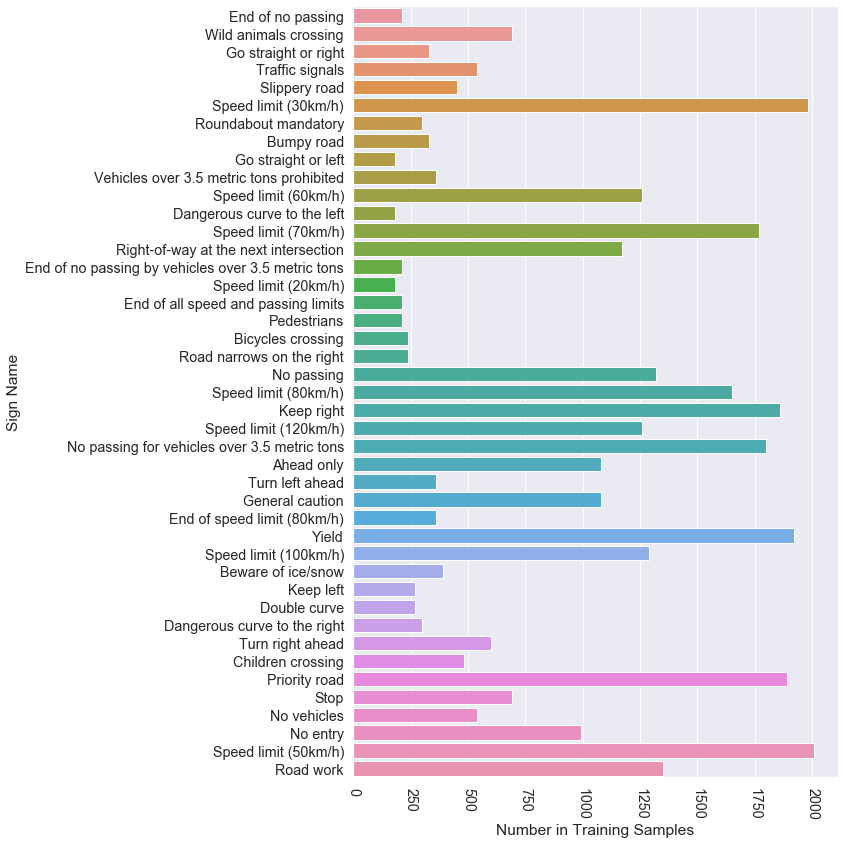

In [5]:
counter = collections.Counter(y_train)
counts = pd.DataFrame(columns=['sign_label','training_samples_count'],data=[(label, count) for label, count in counter.items()])
counts['sign'] = counts.sign_label.apply(get_name_from_label)
plt.figure(figsize=(12,12))
sns.set(font_scale=1.3)
sns.barplot(x='training_samples_count',y='sign',data=counts,orient='o')
plt.xticks(rotation=-90)
plt.ylabel('Sign Name')
plt.xlabel('Number in Training Samples');
plt.tight_layout()
plt.savefig('./img/training_set_counts.png')

In [6]:
def get_random_samples(n_max=1):
    selected = list()    
    for current_label in range(43):
        found=0
        while found<n_max:
            ii = np.random.randint(len(y_train))
            
            if current_label == y_train[ii]:
                selected.append(ii)
                found+=1

    assert len(selected) ==  43*n_max
    return list(selected)

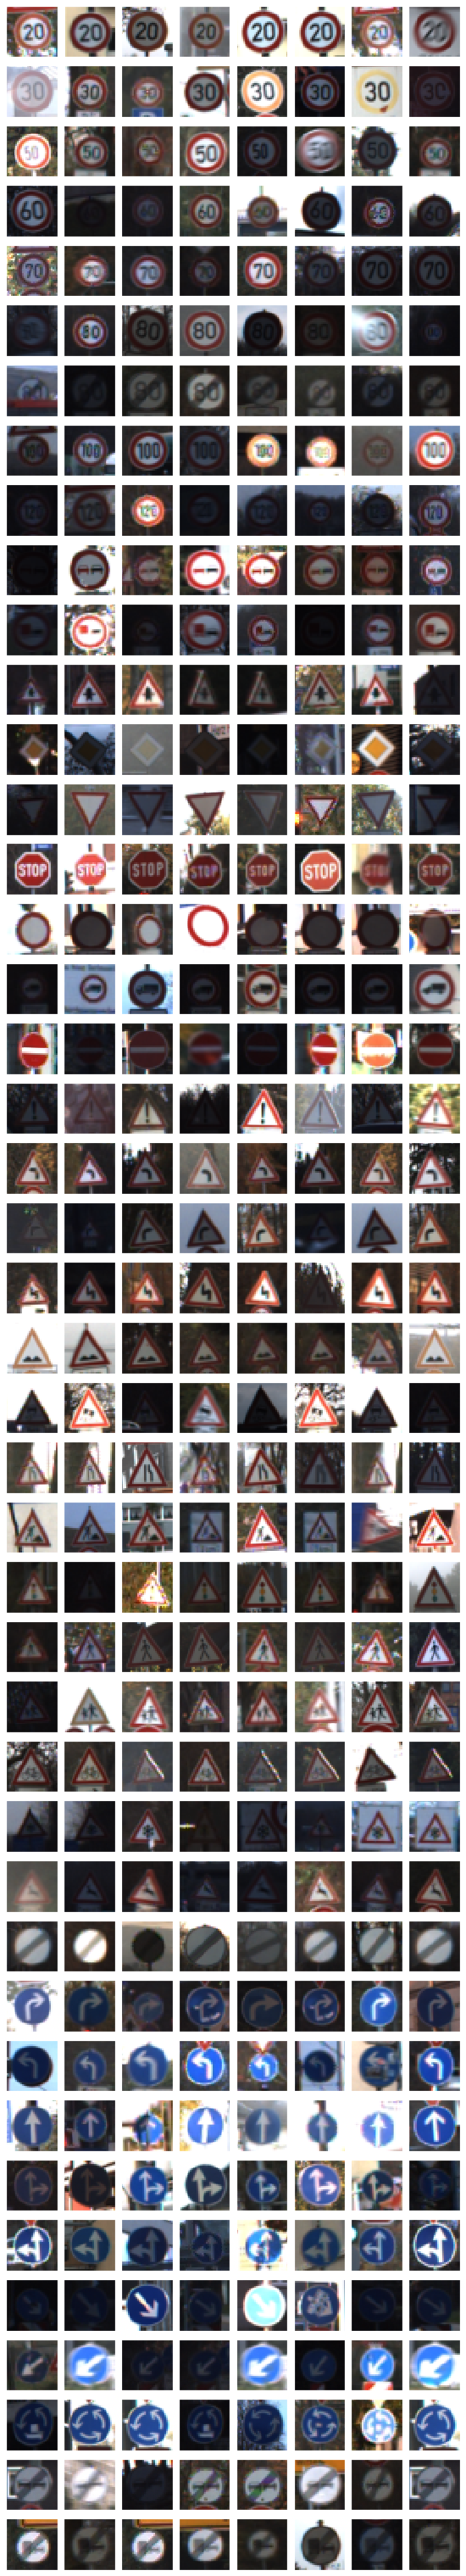

In [23]:
plt.figure(figsize=(8,43))
plt.subplots_adjust(left=0.05, bottom=0.02, right=0.98, top=1, wspace=0.12, hspace=0.001)
count=0
cols = 8
for ii in get_random_samples(cols):
    count+=1
    plt.subplot(43,cols,count)
    plt.imshow(X_train[ii].squeeze())#, cmap='gray'
    plt.xticks([])
    plt.yticks([])
plt.savefig('./img/random_examples.png', dpi=100)
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [8]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
def pre_process(data_set):
    # Grayscale
    data_set_gray = np.sum(data_set/3, axis=3, keepdims=True)
    # Normalize
    data_set_norm = (data_set_gray-128)/128
    return data_set_norm

In [24]:
X_train = pre_process(X_train)
X_valid = pre_process(X_valid)
X_test = pre_process(X_test)
print("X_train image data shape =", X_train.shape)
print("X_valid image data shape =", X_valid.shape)
print("X_test image data shape =", X_test.shape)

X_train image data shape = (34799, 32, 32, 1)
X_valid image data shape = (4410, 32, 32, 1)
X_test image data shape = (12630, 32, 32, 1)


In [12]:
X_train, y_train = shuffle(X_train, y_train)

### Model Architecture

#### Model-I: Traditional LeNet

![LeNet Architecture](./img/lenet.png)
Source: Yan LeCun

In [13]:
### Architecture of traditional LeNet.
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    W1 = tf.Variable(tf.random_normal([5,5,1,6], mu, sigma))
    b1 = tf.Variable(tf.random_normal([6], mu, sigma))
    conv1 = tf.nn.conv2d(x, W1, strides = [1, 1, 1, 1], padding = 'VALID' )
    conv1 = tf.nn.bias_add(conv1, b1)
    # TODO: Activation.
    conv1 = tf.nn.relu(conv1)
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1_out = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'VALID')

    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    W2 = tf.Variable(tf.random_normal([5,5,6,16],mu,sigma))
    b2 = tf.Variable(tf.random_normal([16],mu,sigma))
    conv2 = tf.nn.conv2d(conv1_out, W2, strides = [1, 1, 1, 1], padding = 'VALID' )
    conv2 = tf.nn.bias_add(conv2, b2)
    # TODO: Activation.
    conv2 = tf.nn.relu(conv2)
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2_out = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'VALID')                    

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    fc1_in = Flatten()(conv2_out)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    W3 = tf.Variable(tf.random_normal([400,120],mu,sigma))
    b3 = tf.Variable(tf.random_normal([120],mu,sigma))
    fc1 = tf.add(tf.matmul(fc1_in, W3), b3)
    
    # TODO: Activation.
    fc1_out = tf.nn.relu(fc1)
    
    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    W4 = tf.Variable(tf.random_normal([120,84],mu,sigma))
    b4 = tf.Variable(tf.random_normal([84],mu,sigma))
    fc2 = tf.add(tf.matmul(fc1_out, W4), b4) 
    
    # TODO: Activation.
    fc2_out = tf.nn.relu(fc2)
    
    # TODO: Layer 5: Fully Connected. Input = 84. Output = 10.
    W5 = tf.Variable(tf.random_normal([84,43],mu,sigma))
    b5 = tf.Variable(tf.random_normal([43],mu,sigma))
    logits = tf.add(tf.matmul(fc2_out, W5), b5)    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

#### Model Setting

In [14]:
### Train your model here.
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)

rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
predict_operation = tf.argmax(logits, 1)
predict_proba_operation = tf.nn.softmax(logits=logits)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



#### Model Evaluation

In [15]:
### Calculate and report the accuracy on the training and validation set.
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

#### Train the Model

In [17]:
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.
EPOCHS = 200
BATCH_SIZE = 128

ERRORS = list()
LOSS = list()

start_time = time.time()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    print("-----------------------------------------------------------")
    print("| EPOCH |  LOSS  | Validation Accuracy")
    print("-----------------------------------------------------------")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            _, loss = sess.run([training_operation, loss_operation], feed_dict={x: batch_x, y: batch_y})            
        
        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        
        ERRORS.append((1-training_accuracy,1-validation_accuracy))
        LOSS.append(loss)
        
        print("|%-*s | %-*.3f | %-*.3f " % (6, (i+1), 6, loss, 7, validation_accuracy))
    print("-----------------------------------------------------------")
    print("Time : {}".format(time.time() - start_time))
    
    saver.save(sess, './models/lenet')
    print("Model saved")

Training...

-----------------------------------------------------------
| EPOCH |  LOSS  | Validation Accuracy
-----------------------------------------------------------
|1      | 0.624  | 0.749   
|2      | 0.245  | 0.857   
|3      | 0.342  | 0.875   
|4      | 0.126  | 0.891   
|5      | 0.196  | 0.904   
|6      | 0.030  | 0.907   
|7      | 0.155  | 0.907   
|8      | 0.086  | 0.902   
|9      | 0.024  | 0.916   
|10     | 0.073  | 0.895   
|11     | 0.024  | 0.905   
|12     | 0.025  | 0.915   
|13     | 0.011  | 0.898   
|14     | 0.066  | 0.905   
|15     | 0.047  | 0.910   
|16     | 0.007  | 0.908   
|17     | 0.023  | 0.909   
|18     | 0.070  | 0.914   
|19     | 0.002  | 0.923   
|20     | 0.031  | 0.905   
|21     | 0.005  | 0.905   
|22     | 0.005  | 0.917   
|23     | 0.002  | 0.920   
|24     | 0.041  | 0.906   
|25     | 0.005  | 0.913   
|26     | 0.003  | 0.923   
|27     | 0.001  | 0.917   
|28     | 0.005  | 0.926   
|29     | 0.002  | 0.922   
|30     | 0.000 

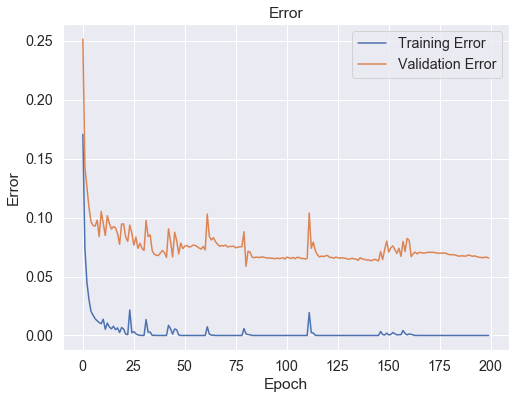

In [18]:
plt.figure(figsize=(8,6))
plt.tight_layout()
plt.title('Error')
plt.plot([el[0] for el in ERRORS])
plt.plot([el[1] for el in ERRORS])
plt.legend(['Training Error','Validation Error'])
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.savefig('./img/learning_curve_error.png', dpi=100)

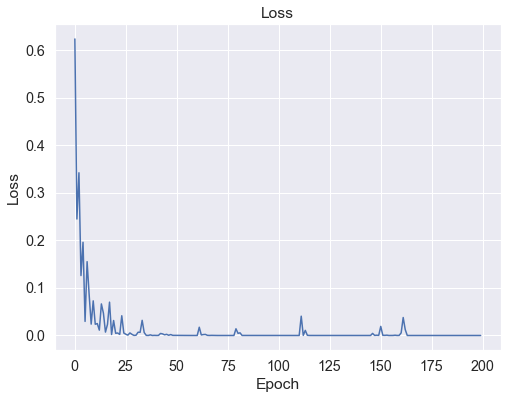

In [19]:
plt.figure(figsize=(8,6))
plt.tight_layout()
plt.title('Loss')
plt.plot(LOSS)
# plt.ylim([-.01,0.35])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.savefig('./img/learning_curve_loss.png', dpi=100)

#### Log of Training on LeNet
|TIME      |ACCURACY  |EPOCHS    |BATCH_SIZE|LEARNING RATE|Time         |
|:--------:|:---------|----------|----------|-------------|------------:|
|2019-12-7 |92.7%     |100       |128       |0.001        |223.922      |
|2019-12-8 |92.4%     |100       |64        |0.001        |357.654      |
|2019-12-8 |87.3%     |100       |128       |0.0001       |222.185      |
|2019-12-8 |93.4%     |200       |128       |0.001        |449.605      |

#### Test the model

In [21]:
with tf.Session() as sess:
    saver.restore(sess, './models/lenet') 

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./models/lenet
Test Accuracy = 0.924


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

### Load and Output the Images

In [25]:
def img_pro(img):
    # Image grayscale
    img_gray = np.sum(img/3, axis=2, keepdims=True).squeeze()
    
    # Image normalize
    img_norm = (img_gray-128)/128
    
    # Image reshape
    img_resize = cv2.resize(img_norm, (32,32), interpolation=cv2.INTER_AREA)
    img_reshape = np.reshape(img_resize, [32, 32 ,1])
    return img_reshape

In [26]:
### Load the images and plot them here.
import os
import cv2
import matplotlib.image as mpimg
# 00000.ppm to 00019.ppm was chosen 
test_imgs_path = './GTSRB_data/Test01/'
test_imgs_name = os.listdir(test_imgs_path)

imgs = []
for file in test_imgs_name:
    img = mpimg.imread(test_imgs_path+file)
    img_res = img_pro(img)
    imgs.append(img_res)

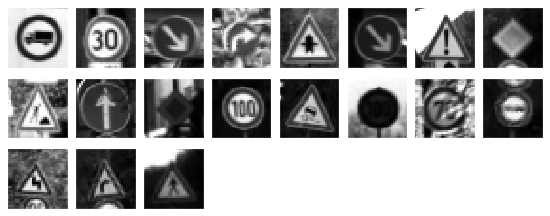

In [27]:
plt.figure(figsize=(8,3))
plt.subplots_adjust(left=0.05, bottom=0.02, right=0.98, top=1, wspace=0.12, hspace=0.001)
for i in range(1,20):
    plt.subplot(3,8,i)
    plt.imshow(imgs[i-1].squeeze(), cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

### Predict the Sign Type for Each Image

In [28]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
def predict(image):
    #x = tf.placeholder(dtype=tf.float64, shape=[None, 32, 32, 1])
    with tf.Session() as sess:
        saver.restore(sess, './models/lenet')      
        print("Model restored.")
        prediction_result = sess.run([tf.argmax(logits, 1)], feed_dict={x: image, keep_prob: 1.0})
        top_5 = sess.run(tf.nn.top_k(tf.nn.softmax(logits), 5), feed_dict={x: image, keep_prob: 1.0})    
    return prediction_result, top_5

In [29]:
prediction_result,top_5 = predict(imgs)

INFO:tensorflow:Restoring parameters from ./models/lenet
Model restored.


### Analyze Performance

In [30]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
ground_truth_result = [16, 1, 38, 33, 11, 38, 18, 12, 25, 35, 12, 7, 23, 7, 4, 9, 21, 20, 27, 38]
print("-----------------------------------------------------------")
print("|Prediction |Ground Truth |T/F")
print("-----------------------------------------------------------")
right = 0
wrong = 0
for i in range(20):
    if prediction_result[0][i] == ground_truth_result[i]:
        right += 1
        print("|%-*s |%-*s |T " % (10, prediction_result[0][i], 12, ground_truth_result[i]))
    else:
        wrong += 1
        print("|%-*s |%-*s |F " % (10, prediction_result[0][i], 12, ground_truth_result[i]))
print("-----------------------------------------------------------")
print("Accuracy of Prediction = {:.2f}".format(right/(wrong+right)))

-----------------------------------------------------------
|Prediction |Ground Truth |T/F
-----------------------------------------------------------
|16         |16           |T 
|1          |1            |T 
|38         |38           |T 
|33         |33           |T 
|11         |11           |T 
|38         |38           |T 
|18         |18           |T 
|12         |12           |T 
|25         |25           |T 
|35         |35           |T 
|12         |12           |T 
|7          |7            |T 
|23         |23           |T 
|8          |7            |F 
|4          |4            |T 
|9          |9            |T 
|21         |21           |T 
|20         |20           |T 
|27         |27           |T 
|38         |38           |T 
-----------------------------------------------------------
Accuracy of Prediction = 0.95


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [31]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
top_5_k = top_5.indices
top_5_p = top_5.values
for i in range(len(top_5_k)):
    print("============================================================")
    print('Top 5 predictions for image: %s' % test_imgs_name[i])
    print("|Label|Sign Name                                |Probability")
    print("------------------------------------------------------------")
    for j in range(len(top_5_k[i])):
        print("|%-*s |%-*s |%-*.3f " % (4, top_5_k[i][j], 40, get_name_from_label(top_5_k[i][j]), 7, top_5_p[i][j])) 

Top 5 predictions for image: 00000.ppm
|Label|Sign Name                                |Probability
------------------------------------------------------------
|16   |Vehicles over 3.5 metric tons prohibited |1.000   
|0    |Speed limit (20km/h)                     |0.000   
|1    |Speed limit (30km/h)                     |0.000   
|2    |Speed limit (50km/h)                     |0.000   
|3    |Speed limit (60km/h)                     |0.000   
Top 5 predictions for image: 00001.ppm
|Label|Sign Name                                |Probability
------------------------------------------------------------
|1    |Speed limit (30km/h)                     |1.000   
|0    |Speed limit (20km/h)                     |0.000   
|2    |Speed limit (50km/h)                     |0.000   
|3    |Speed limit (60km/h)                     |0.000   
|4    |Speed limit (70km/h)                     |0.000   
Top 5 predictions for image: 00002.ppm
|Label|Sign Name                                |Probabilit

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

In [43]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.xticks([])
            plt.yticks([])
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.xticks([])
            plt.yticks([])
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.xticks([])
            plt.yticks([])
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.xticks([])
            plt.yticks([])
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

INFO:tensorflow:Restoring parameters from ./models/lenet
Conv2D_1: 


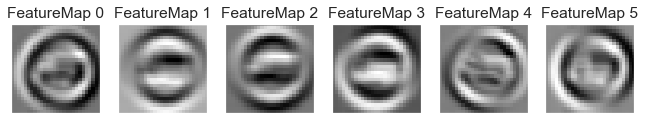

In [48]:
with tf.Session() as sess:
    saver.restore(sess, './models/lenet')
    Conv2D = sess.graph.get_tensor_by_name('Conv2D:0')
    print("Conv2D_1: ")
    outputFeatureMap(imgs, Conv2D)

INFO:tensorflow:Restoring parameters from ./models/lenet
Relu_1:


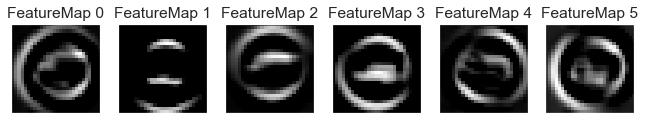

In [50]:
with tf.Session() as sess:
    saver.restore(sess, './models/lenet')
    Relu = sess.graph.get_tensor_by_name('Relu:0')
    print("Relu_1:")
    outputFeatureMap(imgs, Relu)

INFO:tensorflow:Restoring parameters from ./models/lenet
MaxPool_1:


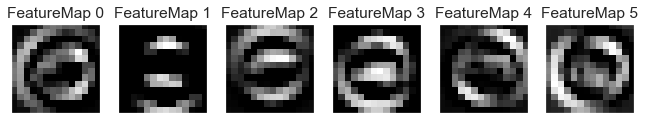

In [51]:
with tf.Session() as sess:
    saver.restore(sess, './models/lenet')
    MaxPool = sess.graph.get_tensor_by_name('MaxPool:0')
    print("MaxPool_1:")
    outputFeatureMap(imgs, MaxPool)

INFO:tensorflow:Restoring parameters from ./models/lenet
Conv2D_2:


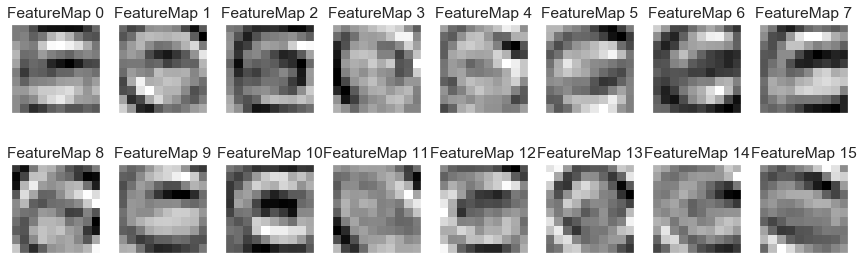

In [52]:
with tf.Session() as sess:
    saver.restore(sess, './models/lenet')
    Conv2D_1 = sess.graph.get_tensor_by_name('Conv2D_1:0')
    print("Conv2D_2:")
    outputFeatureMap(imgs, Conv2D_1)

INFO:tensorflow:Restoring parameters from ./models/lenet
Relu_2:


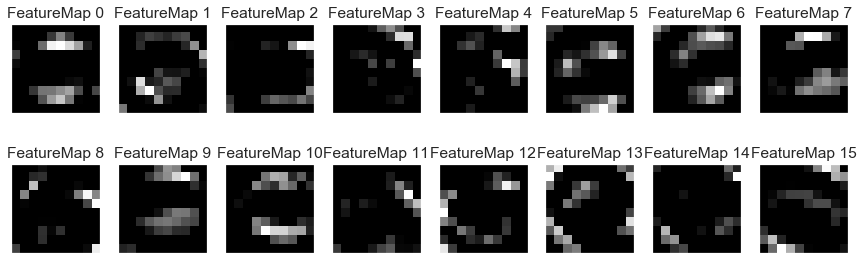

In [53]:
with tf.Session() as sess:
    saver.restore(sess, './models/lenet')
    Relu_1 = sess.graph.get_tensor_by_name('Relu_1:0')
    print("Relu_2:")
    outputFeatureMap(imgs, Relu_1)

INFO:tensorflow:Restoring parameters from ./models/lenet
MaxPool_2:


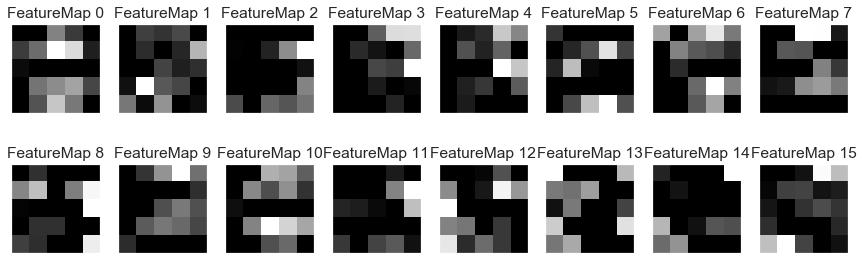

In [54]:
with tf.Session() as sess:
    saver.restore(sess, './models/lenet')
    MaxPool_1 = sess.graph.get_tensor_by_name('MaxPool_1:0')
    print("MaxPool_2:")
    outputFeatureMap(imgs, MaxPool_1)

In [35]:
[n.name for n in tf.get_default_graph().as_graph_def().node]

['Placeholder',
 'Placeholder_1',
 'one_hot/on_value',
 'one_hot/off_value',
 'one_hot/depth',
 'one_hot',
 'Placeholder_2',
 'random_normal/shape',
 'random_normal/mean',
 'random_normal/stddev',
 'random_normal/RandomStandardNormal',
 'random_normal/mul',
 'random_normal',
 'Variable',
 'Variable/Assign',
 'Variable/read',
 'random_normal_1/shape',
 'random_normal_1/mean',
 'random_normal_1/stddev',
 'random_normal_1/RandomStandardNormal',
 'random_normal_1/mul',
 'random_normal_1',
 'Variable_1',
 'Variable_1/Assign',
 'Variable_1/read',
 'Conv2D',
 'BiasAdd',
 'Relu',
 'MaxPool',
 'random_normal_2/shape',
 'random_normal_2/mean',
 'random_normal_2/stddev',
 'random_normal_2/RandomStandardNormal',
 'random_normal_2/mul',
 'random_normal_2',
 'Variable_2',
 'Variable_2/Assign',
 'Variable_2/read',
 'random_normal_3/shape',
 'random_normal_3/mean',
 'random_normal_3/stddev',
 'random_normal_3/RandomStandardNormal',
 'random_normal_3/mul',
 'random_normal_3',
 'Variable_3',
 'Variable_